# Exploring images

* Min values $> 0$ in both modalities $\Rightarrow$ `voxelArrayShift`$=0$.
* Detecting outliers?

In [1]:
import sys
sys.path.append('../src')

import nrrd
import ioutil

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
np.set_printoptions(precision=2)

In [3]:
ct_paths = ioutil.relative_paths(
    './../../data/images/ct_cropped_prep', target_format='nrrd'
)
pet_paths = ioutil.relative_paths(
    './../../data/images/pet_cropped_prep', target_format='nrrd'
)
masks_paths = ioutil.relative_paths(
    './../../data/images/masks_cropped_prep/', target_format='nrrd'
)

In [4]:
def cropped_image_info(path_images, path_masks):
    
    image_data, metadata, num = [], [], []
    for image_path, mask_path in zip(path_images, path_masks):
        raw_image_data, header = nrrd.read(image_path)
        mask, _ = nrrd.read(mask_path)
        data = raw_image_data * mask
        header['min'] = np.min(data)
        header['max'] = np.max(data)
        header['num_unique'] = np.unique(data).size
        header['std'] = np.std(data)

        num.append(ioutil.sample_num(image_path))
        image_data.append(data), metadata.append(header)
        
    return dict(zip(*(num, image_data))), pd.DataFrame(metadata, index=num)

## External CT Statistics

Per patient

In [5]:
ct_data, ct_mdata = cropped_image_info(ct_paths, masks_paths)
ct_mdata.head()

,type,dimension,sizes,endian,encoding,min,max,num_unique,std
2,double,3,"[82, 83, 68]",little,gzip,0.0,1450.980316,2459,205.383480
4,double,3,"[69, 64, 74]",little,gzip,0.0,1414.363699,4280,184.759833
5,double,3,"[73, 70, 82]",little,gzip,0.0,1763.283818,4641,213.666088
8,double,3,"[81, 106, 114]",little,gzip,0.0,1534.148775,4945,271.031115
10,double,3,"[72, 72, 72]",little,gzip,0.0,1364.937514,1907,179.669827


Averaged

In [6]:
ct_mdata.mean(axis=0)

dimension        3.000000
min              0.000000
max           1563.920754
num_unique    3532.803030
std            199.070559
dtype: float64

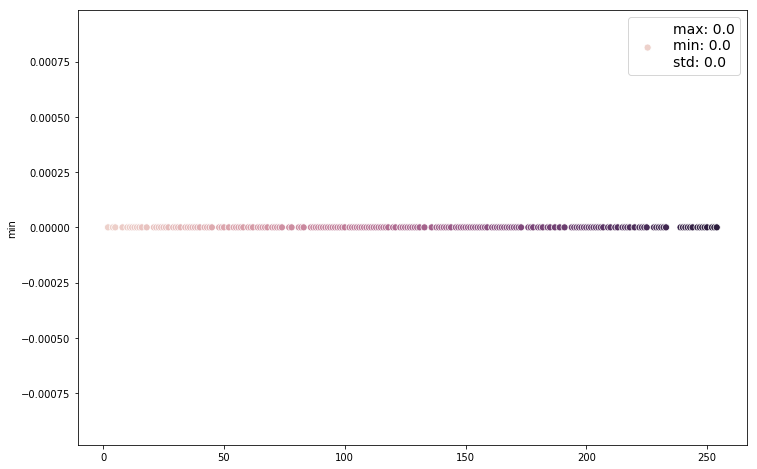

In [7]:
plt.figure(figsize=(12, 8))
sns.scatterplot(
    x=ct_mdata.index, y='min', data=ct_mdata, hue=ct_mdata.index, s=50
);
plt.legend(
    [
            'max: {}\nmin: {}\nstd: {}'.format(
                np.max(ct_mdata['min']),
                np.min(ct_mdata['min']),
                np.std(ct_mdata['min'])
            )
    ], loc='best', fontsize=14
);

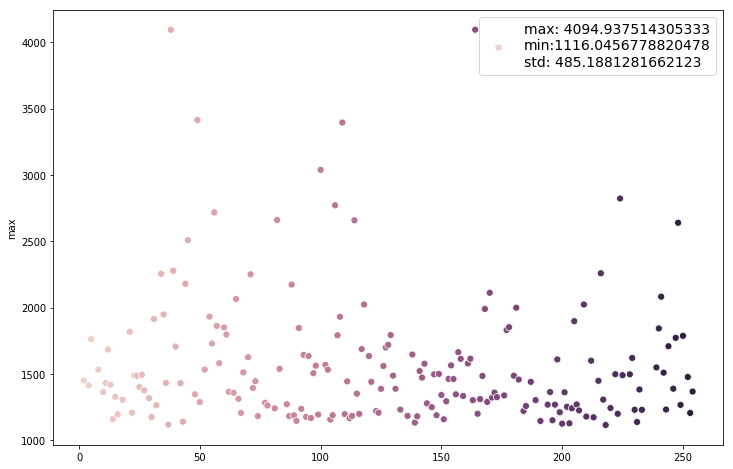

In [8]:
plt.figure(figsize=(12, 8))
sns.scatterplot(
    x=ct_mdata.index, y='max', data=ct_mdata, hue=ct_mdata.index, s=50
);
plt.legend(
    [
            'max: {}\nmin:{}\nstd: {}'.format(
                np.max(ct_mdata['max']), 
                np.min(ct_mdata['max']),
                np.std(ct_mdata['max'])
            )
    ], loc='best', fontsize=14
);

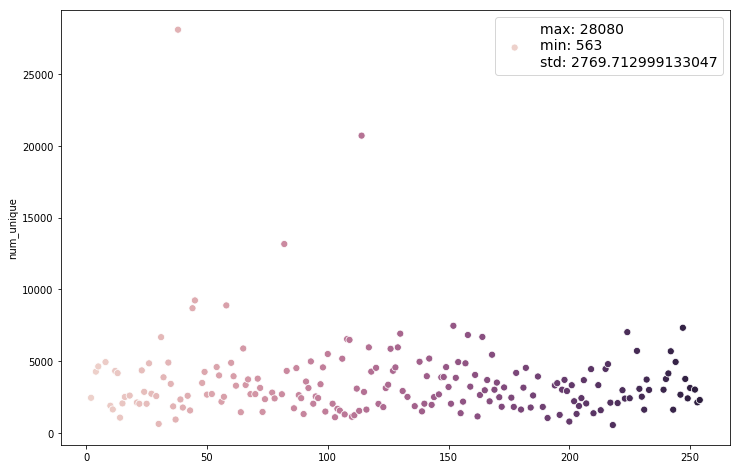

In [9]:
plt.figure(figsize=(12, 8))
sns.scatterplot(
    x=ct_mdata.index, y='num_unique', data=ct_mdata, hue=ct_mdata.index, s=50
);
plt.legend(
    [
        'max: {}\nmin: {}\nstd: {}'.format(
            np.max(ct_mdata.num_unique), 
            np.min(ct_mdata.num_unique),
            np.std(ct_mdata.num_unique)
        )
    ], loc='best', fontsize=14
);

### Fixed bin width

Determine the fixed bin widths based on average number of unique intensity values across scans.

In [10]:
avg_ct_range = ct_mdata.mean()['max'] - ct_mdata.mean()['min']
print('Average range: {}'.format(avg_ct_range))

Average range: 1563.9207535082262


Binned widths: [52.13 28.43 19.55 14.89 12.03]


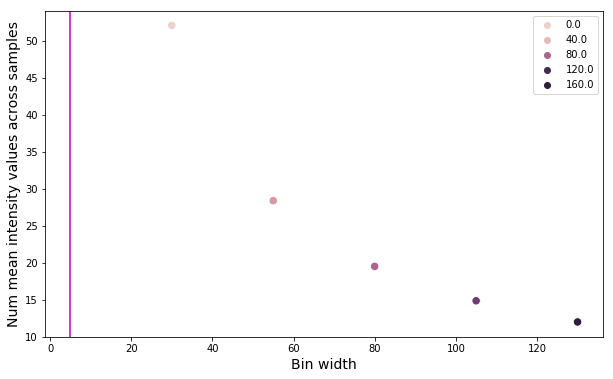

In [11]:
nbins = 5
# NOTE: According to pyradiomics recommendations, te optimal number of 
# bins ranges from 30 to 130.
bin_widths = np.linspace(30, 130, nbins)

plt.figure(figsize=(10, 6))
sns.scatterplot(
    x=bin_widths, y=avg_ct_range / bin_widths, hue=bin_widths, 
    s=70
);
plt.xlabel('Bin width', fontsize=14), 
plt.ylabel('Num mean intensity values across samples', fontsize=14);
plt.axvline(x=nbins, c='m');
print('Binned widths: {}'.format(avg_ct_range / bin_widths))

## External PET Statistics

Compare statistics between patients.

In [12]:
pet_data, pet_mdata = cropped_image_info(pet_paths, masks_paths)
pet_mdata.head()

,type,dimension,sizes,endian,encoding,min,max,num_unique,std
2,double,3,"[82, 83, 68]",little,gzip,0.0,24.741200,14636,2.320645
4,double,3,"[69, 64, 74]",little,gzip,0.0,18.655424,8278,1.386705
5,double,3,"[73, 70, 82]",little,gzip,0.0,16.739500,14048,1.631462
8,double,3,"[81, 106, 114]",little,gzip,0.0,14.210913,30803,1.419874
10,double,3,"[72, 72, 72]",little,gzip,0.0,8.792835,8599,0.748462


Average

In [13]:
pet_mdata.mean(axis=0)

dimension         3.000000
min               0.000000
max              13.175777
num_unique    15005.595960
std               1.245377
dtype: float64

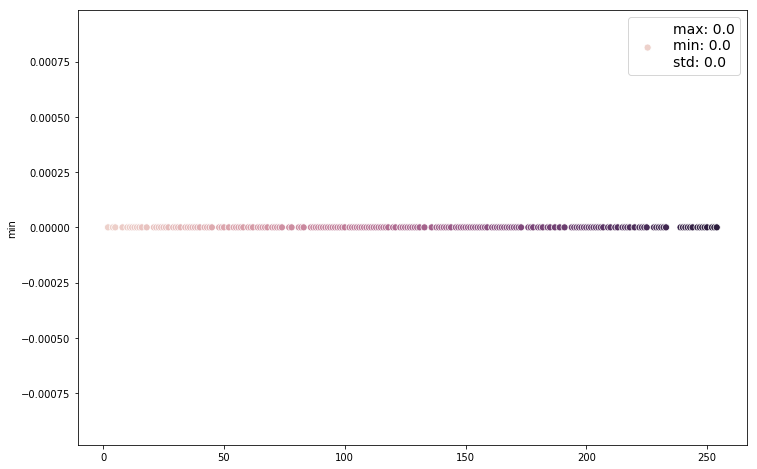

In [14]:
plt.figure(figsize=(12, 8))
sns.scatterplot(
    x=pet_mdata.index, y='min', data=pet_mdata, hue=pet_mdata.index, s=50
);
plt.legend(
    [
            'max: {}\nmin: {}\nstd: {}'.format(
                np.max(pet_mdata['min']), 
                np.min(pet_mdata['min']),
                np.std(pet_mdata['min'])
            )
    ], loc='best', fontsize=14
);

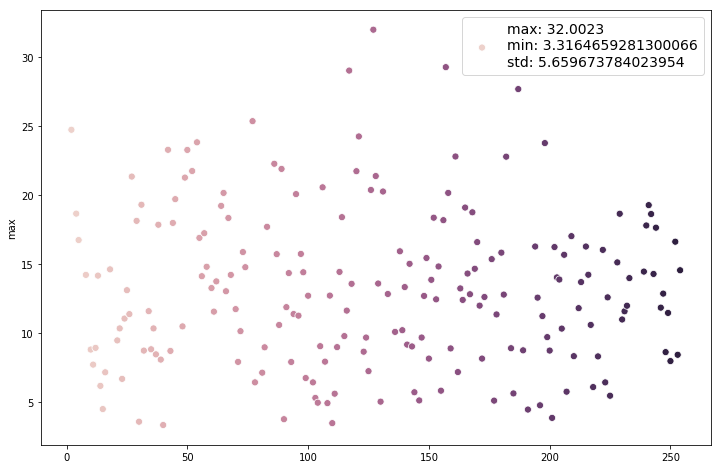

In [15]:
plt.figure(figsize=(12, 8))
sns.scatterplot(
    x=pet_mdata.index, y='max', data=pet_mdata, hue=pet_mdata.index, s=50
);
plt.legend(
    [
            'max: {}\nmin: {}\nstd: {}'.format(
                np.max(pet_mdata['max']), 
                np.min(pet_mdata['max']),
                np.std(pet_mdata['max'])
            )
    ], loc='best', fontsize=14
);

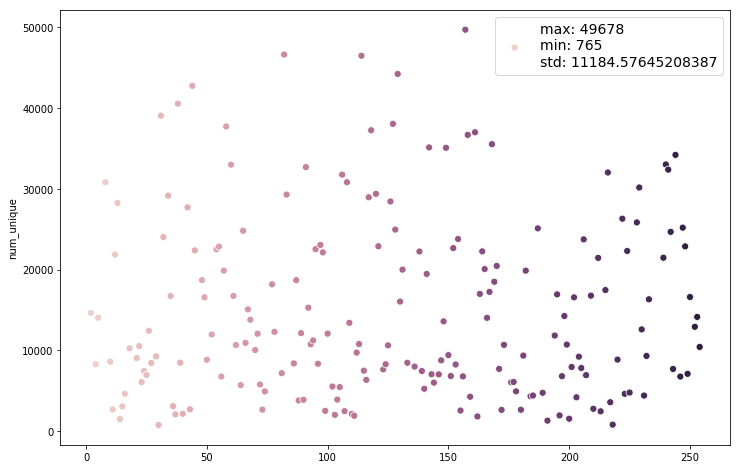

In [16]:
plt.figure(figsize=(12, 8))
sns.scatterplot(
    x=pet_mdata.index, y='num_unique', data=pet_mdata, hue=pet_mdata.index, s=50
);
plt.legend(
    [
        'max: {}\nmin: {}\nstd: {}'.format(
            np.max(pet_mdata.num_unique), 
            np.min(pet_mdata.num_unique),
            np.std(pet_mdata.num_unique)
        )
    ], loc='best', fontsize=14
);

### Fixed bin width

In [17]:
avg_pet_range = pet_mdata.mean()['max'] - pet_mdata.mean()['min']
print('Average range: {}'.format(avg_pet_range))

Average range: 13.175776940151492


Binned widths: [0.44 0.24 0.16 0.13 0.1 ]


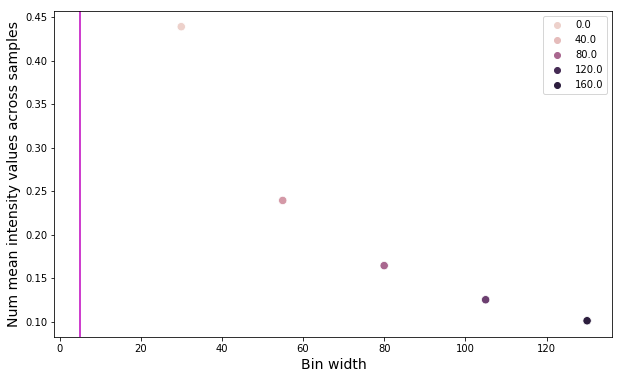

In [18]:
nbins = 5
# NOTE: According to pyradiomics recommendations, te optimal number of 
# bins ranges from 30 to 130.
bin_widths = np.linspace(30, 130, nbins)

plt.figure(figsize=(10, 6))
sns.scatterplot(
    x=bin_widths, y=avg_pet_range/bin_widths, hue=bin_widths, 
    s=70
);
plt.xlabel('Bin width', fontsize=14), 
plt.ylabel('Num mean intensity values across samples', fontsize=14);
plt.axvline(x=nbins, c='m');
print('Binned widths: {}'.format(avg_pet_range / bin_widths))